In [92]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import math

In [113]:
n = 2**10
t = 10**4
p = 0.0154
omega = 1
size = 1
k = 1

In [94]:
def buy_sell_hold(p):
    assert p <= 0.5, "p should be smaller than 0.5"
    p_b = p # buy/sell
    p_s = p
    p_h = 1 - 2*p # hold
    dice = rnd.uniform(0, 1)
    # if the dice rolls below p, roll a 50/50 dice to decide buy or sell
    if dice <= 2*p:
        if rnd.choice([0, 1]) == 0:
            psi = 1
        else:
            psi = -1
    else:
        psi = 0
    return psi

In [95]:
class Agent:
    def __init__(self, size) -> None:
        self.size = size

class Model:
    def __init__(self, p: float, n: int, size: int, k: int, omega: int) -> None:
        self.n = n
        self.p = p
        self.agents = [Agent(size) for i in range(n)]
        self.daily_return = []
        self.trading_volume = 0
        self.k = k
        self.omega = omega
        self.daily_returns = []
        self.count = 0

        self.daily_trading_volumes = []

        
    def distribute_opinion_groups(self) -> None:

        # number of opinion groups
        if sum(self.daily_return) != 0:
            c = (self.n // abs(sum(self.daily_return))) ** self.omega
        else:
            c = self.n
            
        
        opinion_groups = [[] for i in range(c)]
        opinion_agents = self.agents.copy()

        # distribute agents evenly
        for opinion_group in opinion_groups:
            for i in range(round(self.n / c)):
                if len(opinion_agents) > 0:
                    i = rnd.choice([i for i in range(len(opinion_agents))])

                    opinion_group.append(opinion_agents[i])
                    del opinion_agents[i]
                else:
                    break
                
        return opinion_groups

    def step(self):
        self.count += 1
        opinion_groups = self.distribute_opinion_groups()
        self.daily_return = []
        self.trading_volume = 0

        for opinion_group in opinion_groups:
            psi = buy_sell_hold(self.p)
            self.daily_return.append(psi * len(opinion_group))
            self.trading_volume += abs(psi * len(opinion_group))
    
        self.daily_returns.append(sum(self.daily_return) * k)
        self.daily_trading_volumes.append(self.trading_volume)

        return self.count

In [114]:
# ABM

model_test = Model(p, n, size, k, omega)
for i in range(t):
    model_test.step()


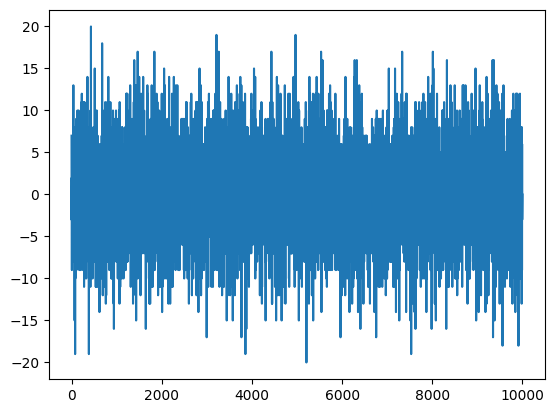

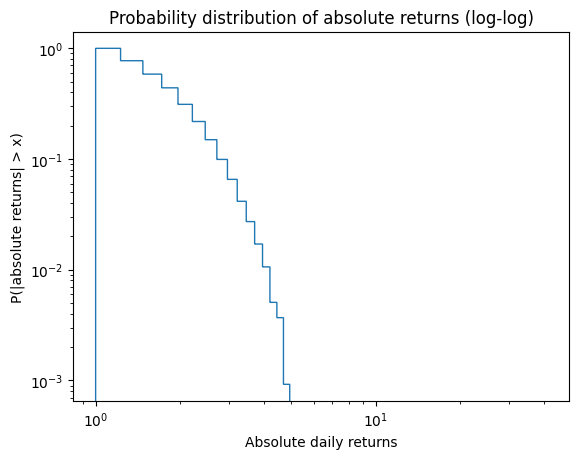

In [112]:
# logarithmic bins
bin=np.logspace(start=0, stop=np.log(5), num=t)

# normalised returns
returns = [(abs(day) - np.mean(model_test.daily_returns)) / np.std(model_test.daily_returns) for day in model_test.daily_returns]

plt.plot(model_test.daily_returns)
plt.show()

plt.figure(1)
plt.hist(returns, bin, cumulative=-1, density=True, log=True, histtype='step')
plt.title("Probability distribution of absolute returns (log-log)")
plt.xlabel("Absolute daily returns")
plt.ylabel("P(|absolute returns| > x)")
plt.gca().set_xscale("log")
plt.show()


In [12]:
class Stochastic_Model:
    def __init__(self, n: int, p: float, init: int, time_horizon: bool, M, d):
        self.returns = [init]
        self.n = n
        self.p = p
        self.time_horizon = time_horizon
        self.M = M
        self.d = d

    def time_horizons(self):
        time_horizons = []
        alpha = []

        # distribution of agents in different time horizons
        # agents are allocated to each time horizon (with exponential decay as we go back in time), until we reach the limit M
        # or until we reach the beginning of the simulation (if current timestep t < M)
        for i in range(1, self.M + 1):
            if len(self.returns) == 1:
                value = (i ** -self.d) * abs(self.returns[-1])
                alpha_val = (i ** -self.d)
                time_horizons.append(value)
                alpha.append(alpha_val)

            elif i >= len(self.returns):
                value = (i ** -self.d) * abs(self.returns[-1] - self.returns[0])
                alpha_val = (i ** -self.d)
                time_horizons.append(value)
                alpha.append(alpha_val)

            else:
                value = (i ** -self.d) * abs(self.returns[-1] - self.returns[-1-i])
                alpha_val = (i ** -self.d)
                time_horizons.append(value)
                alpha.append(alpha_val)

        return sum(time_horizons) * (sum(alpha) ** -1)

    def step(self):

        # Agents only factor in the returns at the previous timestep
        if self.time_horizon == False:
            variance  = 2 * p * n * abs(self.returns[-1])
            std = math.sqrt(variance)
            value = std * np.random.normal(0.0, 1.0)
            self.returns.append(value)
        
        # Agents look back M timesteps
        if self.time_horizon == True:
            horizons = self.time_horizons()
            variance  = 2 * p * n * horizons
            std = math.sqrt(variance)
            value = std * np.random.normal(0.0, 1.0)
            self.returns.append(value)  

In [27]:
# Stochastic simulation

stochastic = Stochastic_Model(n, p, 10, time_horizon=False, M=10, d=1.12)
stochastic_horizons = Stochastic_Model(n, p, 10, time_horizon=True, M=10, d=1.12)

for i in range(t):
    stochastic.step()
    stochastic_horizons.step()

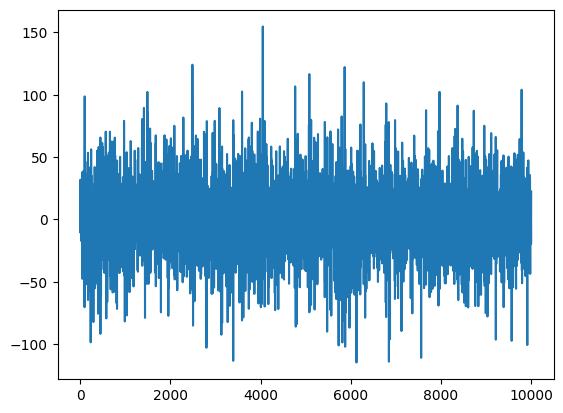

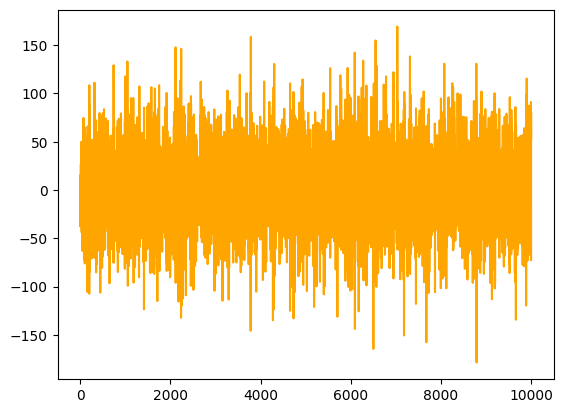

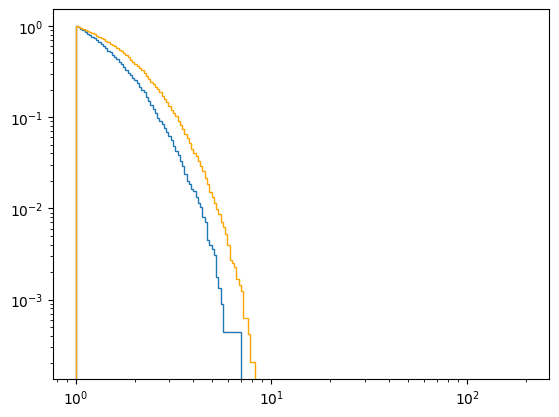

In [110]:
plt.plot(range(t + 1), stochastic.returns)
plt.show()

plt.plot(range(t+1), stochastic_horizons.returns, color='orange')
plt.show()

abs_returns = [(abs(i) - np.mean(abs_returns_horizons)) / (np.std(stochastic.returns)) for i in stochastic.returns]
abs_returns_horizons = [(abs(i) - np.mean(abs_returns)) / (np.std(stochastic.returns)) for i in stochastic_horizons.returns]
bin=np.logspace(start=0, stop=np.log(10), num=200)

plt.hist(abs_returns, bins=bin, cumulative=-1, density=True, log=True, histtype='step')
plt.hist(abs_returns_horizons, bin, cumulative=-1, density=True, log=True, histtype='step', color = 'orange')
plt.gca().set_xscale("log")
plt.show()

In [15]:
def regression(data_x, data_y, alpha, beta, learning_rate, iterations):
    rmse = math.sqrt(np.mean([((alpha + beta * data_x[i]) - data_y[i])**2 for i in range(len(data_y))]))

    for i in range(iterations):
        # find differentials of the parametres
        diff_alpha = 2 * np.mean([(data_x[i] * beta) for i in range(len(data_y))])
        diff_beta = 2 * np.mean([(data_x[i] * beta) * data_x[i] for i in range(len(data_y))])

        alpha_new = alpha - (learning_rate * diff_alpha)
        beta_new = beta - (learning_rate * diff_beta)

        rmse_zero_new = math.sqrt(np.mean([((alpha + beta * data_x[i]) - data_y[i])**2 for i in range(len(data_y))]))

        # keep new parametres if they lead to smaller rmse
        if rmse_zero_new < rmse_zero[-1]:
            alpha = alpha_new
            beta = beta_new
            rmse_zero = rmse_zero_new

    return alpha, beta, rmse

In [ ]:
def r_squared(data, alpha, beta, x_range):
    """
    Goodness of fit test for regression
    """
    ss_res = []
    ss_total = []
    mean = np.mean(data)

    for i in range(x_range):
        prediction = alpha + beta * x_range[i]
        value = data[i]

        residual = (value - prediction) ** 2
        total = (value - mean) ** 2

        ss_res.append(residual)
        ss_total.append(total)

    return 1 - (ss_res / ss_total)


In [ ]:
# k_test - think about ways to fit a power law
k_range = [i*0.1 for i in range(1, 51)]
variances = []

for i in k_range:
    k = i
    k_test = Model(p, n, k, omega)
    for step in range(t):
        k_test.step()

    variance = np.std(k_test) ** 2
    variances.append(variance)

In [ ]:
# k - regression (if beta > 0, there is a relationship)
k_r = regression(k_range, variances, 0, 10, 1000)
k_test = r_squared(variances, k_r[0], k_r[1], k_range)


In [ ]:
# omega_test - think about ways to fit a power law
omega_range = [i*0.1 for i in range(1, 51)]
variances = []

for i in omega_range:
    omega = i
    omega_test = Model(p, n, k, omega)
    for step in range(t):
        omega_test.step()

    variance = np.std(omega_test) ** 2
    variances.append(variance)

In [ ]:
# omega - calculate regression of power law exponent and variances
omega_r = regression(omega_range, variances, 3, 2)
omega_test = r_squared(variances, omega_r[0], omega_r[1], omega_range)


In [48]:
# p_test - variances; mean number of zeros
p_range = [i*0.01 for i in range(1, 101)]
variances = []
zeros = []

for i in p_range:
    p = i
    p_test = Model(p, n, 1, k, omega)
    for step in range(t):
        p_test.step()

    variance = np.std(p_test) ** 2
    variances.append(variance)

    for i in p_test.daily_returns:
        zero = []
        if -0.5 < i < 0.5:
            zero.append(i)
        
        zero_add = sum(zero) / len(p_test.daily_returns)
        zeros.append(zero_add)

KeyboardInterrupt: 

In [46]:
p_zeros_r = regression(p_range, zeros, 5, 5, 1, 1000)
p_variances_r = regression(p_range, variances, 5, 5, 1, 1000)

p_test_zeros = r_squared(zeros, p_zeros_r[0], p_zeros_r[1], p_range)
p_test_variances = r_squared(variances, p_variances_r[0], p_variances_r[1], p_range)



NameError: name 'zeros' is not defined